# [실습2] 인공지능을 활용한 은나노 입자 생성 여부 예측 과정 실습 (정답)
----

## 실습 목차
---
1. 머신러닝을 이용한 타이타닉 생존 예측 연습
1. 은나노 입자 생성 데이터셋에 인공지능 적용을 위한 데이터 준비 및 전처리
1. 다양한 분류 기반 머신러닝 모델(SVM, Tree기반 모델 등)을 활용한 은나노 입자 생성 여부 예측 모델 구현 및 성능 확인

## 실습 개요
---
이번 실습에서는 인공지능을 적용하여 은나노 입자의 생성 여부를 예측하는 AI를 구현합니다.

---
### 라이브러리 불러오기
- **pandas**: 데이터프레임을 다루기 위한 라이브러리
- **seaborn**: 데이터시각화를 위한 라이브러리
- **sklearn**: 머신러닝을 다루기 위한 라이브러리
- **lightgbm**: LightGBM을 다루기 위한 라이브러리
- **xgboost**: xgboost를 다루기 위한 라이브 러리

In [274]:
import pandas as pd

import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score

from lightgbm import LGBMClassifier
from sklearn.tree import DecisionTreeClassifier
from xgboost import XGBClassifier
from sklearn.linear_model import SGDClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB

## 1. 머신러닝을 이용한 타이타닉 생존 예측 연습
---

은나노 입자의 생성 데이터는 교육용으로 가공된 데이터로서 실제 데이터와 달리 데이터가 많지 않습니다.   
때문에 우선 titanic 데이터를 활용하여 다양한 데이터 전처리 기법 및 예측하는 방법을 학습합니다.

**타이타닉 데이터셋**
1912년에 발생한 타이타닉호의 침몰 사고에 관련된 정보를 담고 있는 데이터입니다. 

**컬럼별 의미**

|컬럼명|의미|
|----|----|
|PassengerId | 승객 고유 식별자|
|Survived | 생존 여부 (0: 생존하지 않음, 1: 생존)|
|Pclass | 객실 등급 (1: 1등급, 2: 2등급, 3: 3등급)|
|Name | 승객 이름|
|Sex | 성별|
|Age | 나이|
|SibSp | 함께 탑승한 형제자매 또는 배우자 수|
|Parch | 함께 탑승한 부모 또는 자녀 수|
|Ticket | 티켓 번호|
|Fare | 운임 요금|
|Cabin | 객실 번호|
|Embarked | 탑승 항구 (C: Cherbourg, Q: Queenstown, S: Southampton)|

주요한 열은 "Survived" (생존 여부)이며, 이를 예측하려 합니다. 다른 열들은 승객의 정보를 나타내며, 생존 여부와의 관계를 분석할 수 있습니다. 예를 들어, 성별("Sex")이나 객실 등급("Pclass")이 생존 여부에 영향을 미치는지 등을 확인할 수 있습니다.

### 1.1 타이타닉 데이터셋 EDA

`read_csv()`를 이용하여 titanic 데이터를 로드합니다.

In [275]:
data=pd.read_csv('./data/titanic.csv')

data의 상위 5개 row를 확인합니다.

In [276]:
data.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


각 컬럼의 Null 갯수를 확인합니다.

In [277]:
data.isnull().sum()

PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64

`Age`의 max, min, mean 값을 확인합니다.


In [278]:
print(f"max: {data['Age'].max()}")
print(f"min: {data['Age'].min()}")
print(f"mean: {data['Age'].mean()}")

max: 80.0
min: 0.42
mean: 29.69911764705882


- 탑승객 중 최고령자는 80세 입니다.
- 탑승객 중 최저령자는 0.42세로 갓난 아기도 탑승했음을 알 수 있습니다.
- 탑승객의 평균 나이는 약 29세임을 알 수 있습니다.

describe를 이용하면 다른 통계치도 함께 확인할 수 있습니다.

In [279]:
data.describe()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000
mean,446.000000,0.383838,2.308642,29.699118,0.523008,0.381594,32.204208
std,257.353842,0.486592,0.836071,14.526497,1.102743,0.806057,49.693429
min,1.000000,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,223.500000,0.000000,2.000000,20.125000,0.000000,0.000000,7.910400
50%,446.000000,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,668.500000,1.000000,3.000000,38.000000,1.000000,0.000000,31.000000
max,891.000000,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


- 생존률을 약 38% 임을 알 수 있습니다.
- 대부분의 객실 등급의 수는 3 > 2 > 1 임을 알 수 있습니다.
- 나이의 평균이 약 29세, 표준편차가 약 14세로 대부분의 탑승객이 청년층임을 알 수 있습니다.
- SibSp, Parch의 25% ~ 75%를 보았을 때 많은 승객이 혼자 탑승했음을 알 수 있습니다.
- 탑승료의 중앙값은 약 14, 평균은 32, 75%는 31, 최대값은 512 임을 고려했을 때 일반적인 탑승료와 VIP를 위한 탑승료의 차이가 10배 이상임을 알 수 있습니다.

Name 컬럼 값을 보면 승객의 상태를 나타내는 부분이 있습니다. 이를 학습에 활용하기 위해 전처리 작업을 진행합니다.

In [280]:
data.Name

0                                Braund, Mr. Owen Harris
1      Cumings, Mrs. John Bradley (Florence Briggs Th...
2                                 Heikkinen, Miss. Laina
3           Futrelle, Mrs. Jacques Heath (Lily May Peel)
4                               Allen, Mr. William Henry
                             ...                        
886                                Montvila, Rev. Juozas
887                         Graham, Miss. Margaret Edith
888             Johnston, Miss. Catherine Helen "Carrie"
889                                Behr, Mr. Karl Howell
890                                  Dooley, Mr. Patrick
Name: Name, Length: 891, dtype: object



`Name` 컬럼에서 initial 부분만 가져와 `data`의 `Initial`컬럼에 저장합니다.

In [281]:
data['Initial'] = data.Name.str.extract('([A-Za-z]+)\.')
data['Initial']

0        Mr
1       Mrs
2      Miss
3       Mrs
4        Mr
       ... 
886     Rev
887    Miss
888    Miss
889      Mr
890      Mr
Name: Initial, Length: 891, dtype: object

Sex 별 Initial 수를 확인합니다.

`pd.crosstab`을 이용하여 `data.Initial`, `data.Sex` 의 교차표를 구합니다.

In [282]:
pd.crosstab(data.Initial, data.Sex).T

Initial,Capt,Col,Countess,Don,Dr,Jonkheer,Lady,Major,Master,Miss,Mlle,Mme,Mr,Mrs,Ms,Rev,Sir
Sex,,,,,,,,,,,,,,,,,
female,0,0,1,0,1,0,1,0,0,182,2,1,0,125,1,0,0
male,1,2,0,1,6,1,0,2,40,0,0,0,517,0,0,6,1


- Mr, Mrs, Miss가 대부분임을 알 수 있습니다.

`Initial`을 큰 카테고리를 크게 묶어줍니다.

In [283]:
data['Initial'].replace(
    ['Mlle','Mme','Ms','Dr','Major','Lady','Countess','Jonkheer','Col','Rev','Capt','Sir','Don'],
    ['Miss','Miss','Miss','Mr','Mr','Mrs','Mrs','Other','Other','Other','Mr','Mr','Mr'],
    inplace=True
    )

한번 더 교차표를 구해봅니다.

In [284]:
pd.crosstab(data.Initial, data.Sex).T

Initial,Master,Miss,Mr,Mrs,Other
Sex,,,,,
female,0,186,1,127,0
male,40,0,528,0,9


`Initials`별로 `Age`의 통계치를 확인합니다.

In [285]:
mean_age_by_init = data.groupby('Initial')['Age'].describe()
mean_age_by_init

,count,mean,std,min,25%,50%,75%,max
Initial,,,,,,,,
Master,36.0,4.574167,3.619872,0.42,1.000,3.5,8.0,12.0
Miss,150.0,21.860000,12.828485,0.75,14.625,21.5,30.0,63.0
Mr,409.0,32.739609,12.875632,11.00,23.000,30.0,40.0,80.0
Mrs,110.0,35.981818,11.390469,14.00,28.000,35.0,44.0,63.0
Other,9.0,45.888889,12.604012,27.00,38.000,51.0,56.0,60.0


- Master는 Mr로 불리기에는 어린 남자에 대한 호칭이기에 통계값들이 어리게 나온 것을 확인할 수 있습니다.
- 승객의 대부분이 Mr임을 알 수 있습니다.

`Age`가 null인 경우 `Initials`별로 `Age`의 평균을 참고하여 값을 채웁니다.

In [286]:
# data['Age'] = data.apply(
#     lambda row: mean_age_by_init.loc[row['Initial'], 'mean'] if pd.isnull(row['Age']) else row['Age'], 
#     axis=1)
for initial, mean_age in mean_age_by_init["mean"].reset_index().values:
    data.loc[(data.Age.isnull()) & (data.Initial==initial), 'Age'] = mean_age

통계치를 한번 더 확인합니다.

In [287]:
data.groupby('Initial')['Age'].describe()

,count,mean,std,min,25%,50%,75%,max
Initial,,,,,,,,
Master,40.0,4.574167,3.429216,0.42,1.75,4.000000,7.25,12.0
Miss,186.0,21.860000,11.512845,0.75,16.25,21.860000,26.75,63.0
Mr,529.0,32.739609,11.318313,11.00,25.00,32.739609,36.00,80.0
Mrs,127.0,35.981818,10.594235,14.00,29.00,35.981818,42.50,63.0
Other,9.0,45.888889,12.604012,27.00,38.00,51.000000,56.00,60.0


- null인 부분을 mean 값으로 채웠기 때문에 mean의 값은 동일하지만 count,std, 25%, 50%, 75%는 변한것을 알 수 있습니다.

`Age`에 null 값이 있는지 확인합니다.

In [288]:
data.Age.isnull().any() 

False

가족 구성원의 수를 담은 컬럼을 추가합니다.

In [289]:
data['FamilySize'] = data.SibSp + data.Parch + 1

혼자 탑승했는지에 대한 유무를 담은 컬럼을 추가합니다.

In [290]:
data['IsAlone'] = 1 
data['IsAlone'].loc[data['FamilySize'] > 1] = 0 

# data['IsAlone'] = (data['FamilySize'] == 1).astype(int)

/var/folders/_c/srk70v3s6lz3gmy1_7f12cpw0000gn/T/ipykernel_80928/373990368.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['IsAlone'].loc[data['FamilySize'] > 1] = 0


텍스트 데이터이지만 카테고리컬 한 의미를 가진 컬럼들을 정수형으로 변환합니다.

LabelEncoder를 사용하는 방법도 있지만 컬럼을 category로 변경 후 cat.codes을 이용해 바꾸는 방법도 있습니다.

In [291]:
label = LabelEncoder()

data['Sex_Code'] = label.fit_transform(data['Sex'])
data['Embarked_Code'] = label.fit_transform(data['Embarked'])
data['Initial_Code'] = label.fit_transform(data['Initial'])

# data['Sex_Code'] = data['Sex'].astype('category').cat.codes
# data['Embarked_Code'] = data['Embarked'].astype('category').cat.codes
# data['Initial_Code'] = data['Initial'].astype('category').cat.codes

Pclass별 생존률을 값으로 확인하고 시각화 합니다.

In [292]:
survived_ratio_df = data[['Pclass', 'Survived']].groupby(['Pclass'], as_index=False).mean().sort_values(by='Survived', ascending=False)
survived_ratio_df

,Pclass,Survived
0,1,0.629630
1,2,0.472826
2,3,0.242363


- 1등석일수록 생존률이 높은것을 볼 수 있습니다.

위 내용을 시각화 합니다.

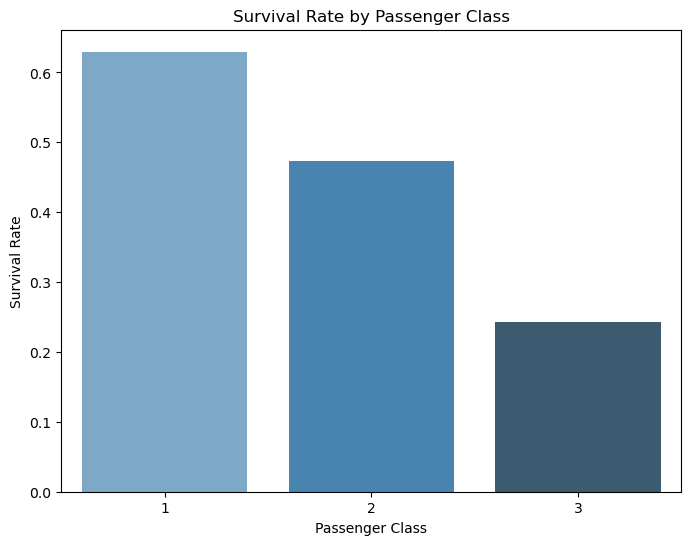

In [293]:
plt.figure(figsize=(8, 6))
sns.barplot(x='Pclass', y='Survived', data=survived_ratio_df, palette="Blues_d")
plt.title('Survival Rate by Passenger Class')
plt.xlabel('Passenger Class')
plt.ylabel('Survival Rate')
plt.show()

이번엔 비율을 생존 유무, 티켓등급으로 나누어 확인합니다.

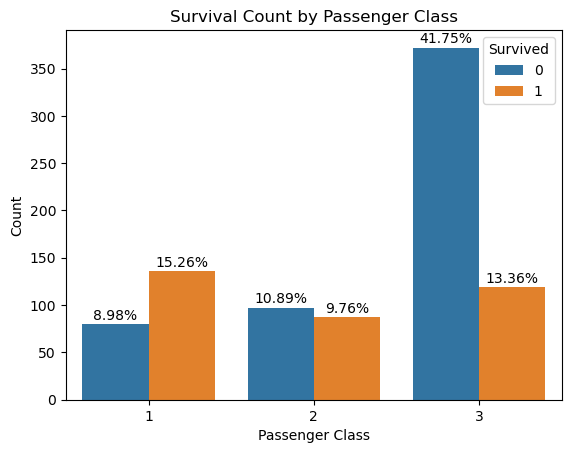

In [294]:
ax = sns.countplot(
    data = data,  # 데이터 프레임
    x = "Pclass",  # x축 변수
    hue = "Survived"  # 범례 변수
)

total = len(data)  # 전체 데이터 개수
for p in ax.patches:  # 막대 그래프의 각 패치에 대해 반복
    height = p.get_height()  # 막대의 높이
    ax.text(p.get_x() + p.get_width() / 2, height + 5, f'{height/total:.2%}', ha="center")  # 막대 위에 텍스트 추가

plt.title('Survival Count by Passenger Class')  # 그래프 제목
plt.xlabel('Passenger Class')  # x축 레이블
plt.ylabel('Count')  # y축 레이블
plt.show()  # 그래프 출력

- 전체 비율 중 3등석의 사망 비율이 41.75%나 되는 것을 확인 할 수 있습니다.

위에서 사용한 코드를 함수화 후 다른 컬럼에 적용합니다.

In [295]:
def plot_survival_rate_by_pclass(col):
    survived_ratio_df = data[[col, 'Survived']].groupby([col], as_index=False).mean().sort_values(by='Survived', ascending=False)
    display(survived_ratio_df)
    
    sns.barplot(x=col, y='Survived', data=survived_ratio_df, palette="Blues_d")
    plt.title(f'Survival Rate by {col}')
    plt.xlabel(col)
    plt.ylabel('Survival Rate')
    plt.show()

,Sex,Survived
0,female,0.742038
1,male,0.188908


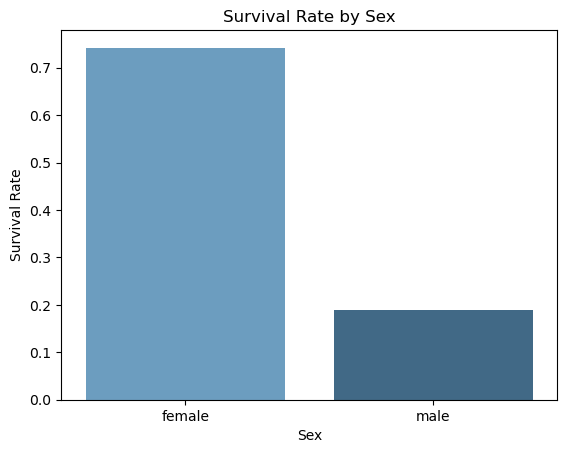

In [296]:
plot_survival_rate_by_pclass("Sex")    

- 여성의 생존률은 약 74%, 남성의 생존률은 약 18% 임을 알 수 있습니다.

이번엔 Parch 컬럼에 대해 알아봅니다.

,Parch,Survived
3,3,0.600000
1,1,0.550847
2,2,0.500000
0,0,0.343658
5,5,0.200000
4,4,0.000000
6,6,0.000000


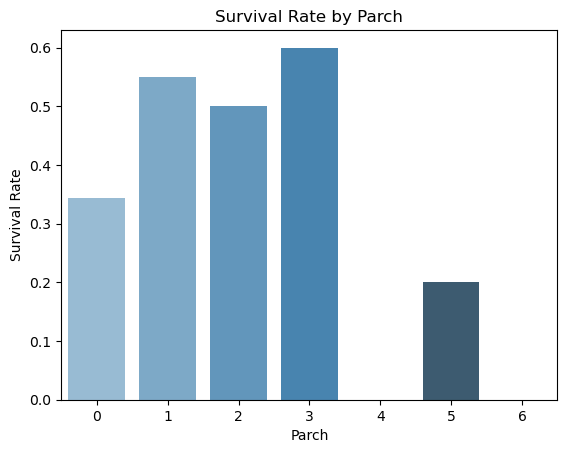

In [297]:
plot_survival_rate_by_pclass("Parch")    

이번엔 SibSp 컬럼에 대해 알아봅니다.

,SibSp,Survived
1,1,0.535885
2,2,0.464286
0,0,0.345395
3,3,0.250000
4,4,0.166667
5,5,0.000000
6,8,0.000000


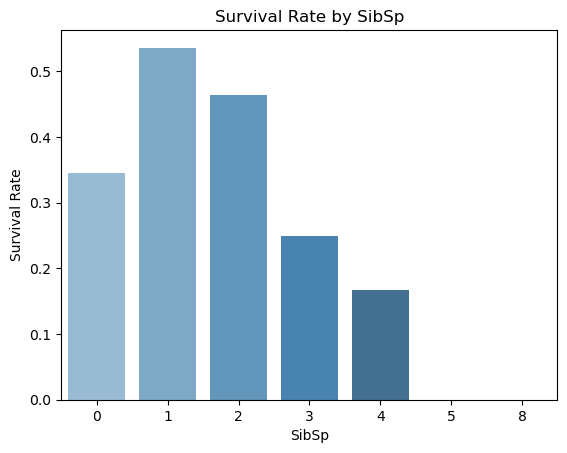

In [298]:
plot_survival_rate_by_pclass("SibSp")    

IsAlone에 대해 알아봅니다.

,IsAlone,Survived
0,0,0.505650
1,1,0.303538


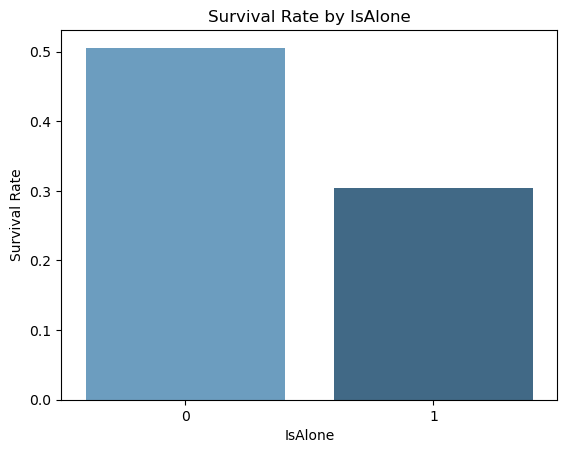

In [299]:
plot_survival_rate_by_pclass("IsAlone")

- 동행이 있을 때 생존율이 더 높은 것을 알 수 있습니다.

동행이 있을 때 생존율이 높은 현상에 대해 더 자세히 살펴보겠습니다.

In [300]:
data.groupby(["Sex", "IsAlone"]).Survived.mean()

Sex     IsAlone
female  0          0.712766
        1          0.785714
male    0          0.271084
        1          0.155718
Name: Survived, dtype: float64

- 여자는 혼자일 때 생존율이 더 높습니다.
- 남자는 동행이 있을 때 생존율이 더 높습니다.

data의 상관계수를 heatmap을 이용하여 확인합니다.   
이를 통해 Survived와 높은 상관계수를 같은 feature를 확인합니다.

이번엔 연령대 컬럼을 만들어 봅니다.

In [301]:
def categorize_age(age):
    if age <= 16:
        return 0
    elif age <= 30:
        return 1
    elif age <= 50:
        return 2
    else:
        return 3

data["age_band"] = data.Age.apply(categorize_age)
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 19 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   PassengerId    891 non-null    int64  
 1   Survived       891 non-null    int64  
 2   Pclass         891 non-null    int64  
 3   Name           891 non-null    object 
 4   Sex            891 non-null    object 
 5   Age            891 non-null    float64
 6   SibSp          891 non-null    int64  
 7   Parch          891 non-null    int64  
 8   Ticket         891 non-null    object 
 9   Fare           891 non-null    float64
 10  Cabin          204 non-null    object 
 11  Embarked       889 non-null    object 
 12  Initial        891 non-null    object 
 13  FamilySize     891 non-null    int64  
 14  IsAlone        891 non-null    int64  
 15  Sex_Code       891 non-null    int64  
 16  Embarked_Code  891 non-null    int64  
 17  Initial_Code   891 non-null    int64  
 18  age_band  

age_band를 시각화 합니다.

,age_band,Survived
0,0,0.548077
1,1,0.385507
2,2,0.343915
3,3,0.343750


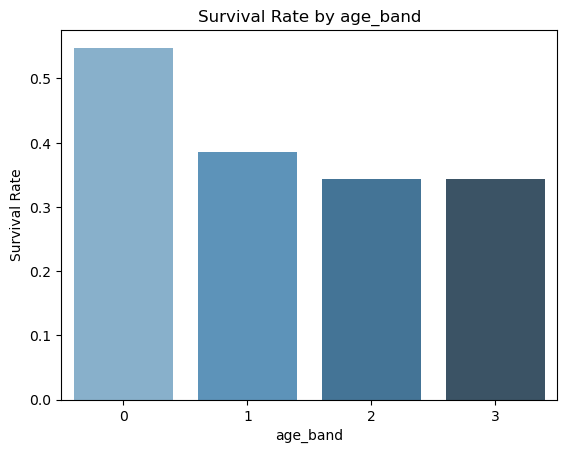

In [302]:
plot_survival_rate_by_pclass("age_band")

- 16세 이하일 때 생존율이 조금 더 높습니다.
- 지금까지의 분석결과를 종합하였을 때 여자, 아이를 더 우선시 구조한 것을 알 수 있습니다.

그렇다면 여자아이의 생존율이 가장 높을지 확인해 봅시다.

In [303]:
data.groupby(["age_band", "Sex"]).mean().Survived

/var/folders/_c/srk70v3s6lz3gmy1_7f12cpw0000gn/T/ipykernel_80928/927163432.py:1: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  data.groupby(["age_band", "Sex"]).mean().Survived


age_band  Sex   
0         female    0.673469
          male      0.436364
1         female    0.710345
          male      0.150000
2         female    0.786408
          male      0.178182
3         female    0.941176
          male      0.127660
Name: Survived, dtype: float64

- 여성의 경우 나이가 많을수록 생존률이 높습니다.
- 남성의 경우 나이가 어릴수록 생존율이 높습니다.

이번엔 Pclass, Sex 별 생존률을 확인하겠습니다.

In [304]:
data.groupby(["Pclass", "Sex"]).mean().Survived

/var/folders/_c/srk70v3s6lz3gmy1_7f12cpw0000gn/T/ipykernel_80928/3406505924.py:1: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  data.groupby(["Pclass", "Sex"]).mean().Survived


Pclass  Sex   
1       female    0.968085
        male      0.368852
2       female    0.921053
        male      0.157407
3       female    0.500000
        male      0.135447
Name: Survived, dtype: float64

- 모든 클래스에서 여성의 생존율이 남성보다 높긴 하지만 대체적으로 성별과 무관하게 Pclass 값이 낮을수록(좋은 class 일수록) 생존률이 증가함을 알 수 있습니다.

히트맵을 이용하여 각 컬럼간의 상관계수를 시각화 하겠습니다.

/var/folders/_c/srk70v3s6lz3gmy1_7f12cpw0000gn/T/ipykernel_80928/432088811.py:3: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  data_corr = data.corr()


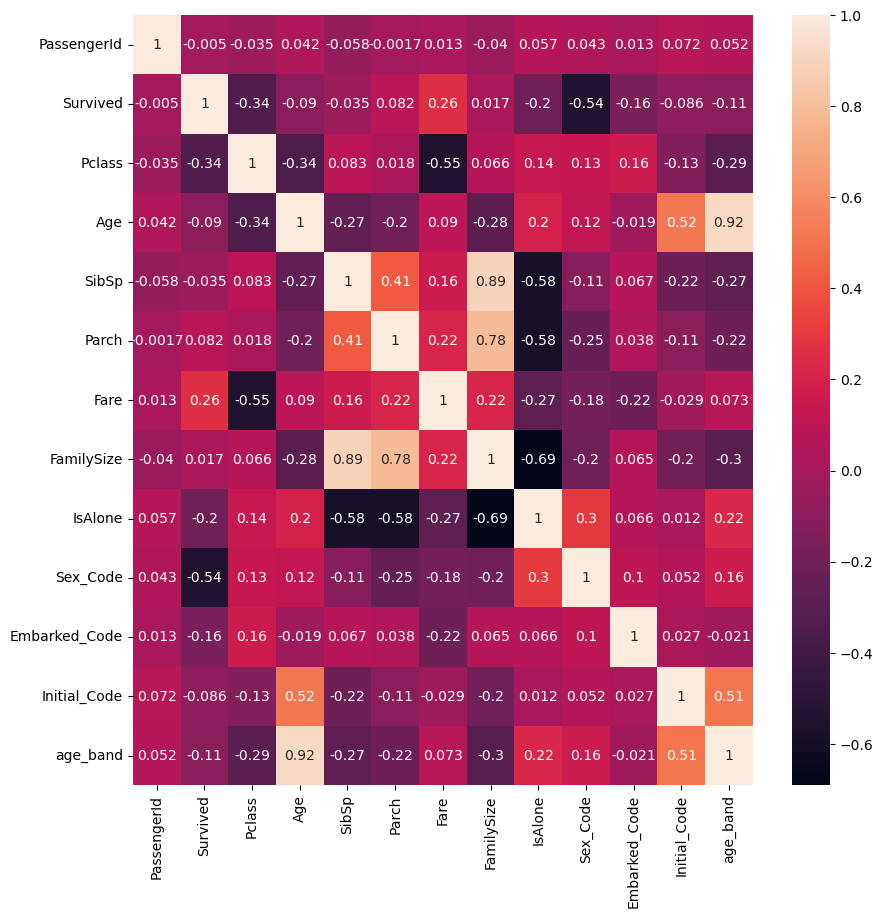

In [305]:
plt.figure(figsize=(10,10))

data_corr = data.corr()
sns.heatmap(data_corr, annot=True)
plt.show()

- 생존여부와 큰 상관관계를 가지는 것은 Sex, Pclass, Fare 임을 알 수 있습니다.

sort_values를 이용하여 상관계수가 큰 순서대로 쉽게 확인할 수 있습니다.

In [306]:
data_corr.sort_values(by="Survived", key=abs, ascending=False)[["Survived"]]

,Survived
Survived,1.000000
Sex_Code,-0.543351
Pclass,-0.338481
Fare,0.257307
IsAlone,-0.203367
Embarked_Code,-0.163517
age_band,-0.108919
Age,-0.090312
Initial_Code,-0.085529
Parch,0.081629


상관계수 정리

- Sex_Code 변수는 -0.543351의 상관 계수를 가지며, 낮은 값이 생존에 긍정적인 영향을 미친다는 것을 의미합니다. 여기서 Sex_Code는 성별을 나타내는 변수로, 여성(0)은 생존에 더 높은 기여를 한 것으로 보입니다.

- Pclass 변수는 -0.338481의 상관 계수를 가지며, 낮은 값이 생존에 긍정적인 영향을 미친다는 것을 의미합니다. Pclass는 승객의 등급을 나타내는 변수로, 등급이 높을수록 생존에 더 높은 기여를 한 것으로 보입니다.

- Fare 변수는 0.257307의 상관 계수를 가지며, 높은 값이 생존에 긍정적인 영향을 미친다는 것을 의미합니다. Fare는 지불한 운임 요금을 나타내는 변수로, 운임 요금이 높을수록 생존에 더 높은 기여를 한 것으로 보입니다.

- Embarked_Code 변수는 -0.163517의 상관 계수를 가지며, 낮은 값이 생존에 긍정적인 영향을 미친다는 것을 의미합니다. Embarked_Code는 승선한 항구를 나타내는 변수로, 특정 항구에서 승선한 승객들이 생존에 더 높은 기여를 한 것으로 보입니다.

- age_band 변수는 -0.108919의 상관 계수를 가지며, 낮은 값이 생존에 긍정적인 영향을 미친다는 것을 의미합니다. age_band는 승객의 연령대를 나타내는 변수로, 나이가 어릴수록 생존에 더 높은 기여를 한 것으로 보입니다.

- Age 변수는 -0.090312의 상관 계수를 가지며, 낮은 값이 생존에 긍정적인 영향을 미친다는 것을 의미합니다. Age는 승객의 나이를 나타내는 변수로, 나이가 어릴수록 생존에 더 높은 기여를 한 것으로 보입니다.

- Initial_Code 변수는 -0.085529의 상관 계수를 가지며, 낮은 값이 생존에 긍정적인 영향을 미친다는 것을 의미합니다. Initial_Code는 승객의 이름에서 추출한 호칭을 나타내는 변수로, 일부 호칭은 생존에 더 높은 기여를 한 것으로 보입니다.

- Parch 변수는 0.081629의 상관 계수를 가지며, 높은 값이 생존에 긍정적인 영향을 미친다는 것을 의미합니다. Parch는 승객과 함께 탑승한 부모 또는 자녀의 수를 나타내는 변수로, 가족 구성원이 많을수록 생존에 더 높은 기여를 한 것으로 보입니다.

- SibSp 변수는 -0.035322의 상관 계수를 가지며, 낮은 값이 생존에 긍정적인 영향을 미친다는 것을 의미합니다. SibSp는 승객과 함께 탑승한 형제 또는 배우자의 수를 나타내는 변수로, 형제/배우자의 수가 적을수록 생존에 더 높은 기여를 한 것으로 보입니다.

- FamilySize 변수는 0.016639의 상관 계수를 가지며, 높은 값이 생존에 긍정적인 영향을 미친다는 것을 의미합니다. FamilySize는 승객의 가족 구성원 수를 나타내는 변수로, 가족 구성원 수가 많을수록 생존에 더 높은 기여를 한 것으로 보입니다.

- PassengerId 변수는 -0.005007의 상관 계수를 가지며, 생존과 거의 관련이 없다는 것을 의미합니다. PassengerId는 승객의 고유 식별자를 나타내는 변수로, 생존과의 연관성이 낮은 것으로 보입니다.


### 1.2 타이타닉 데이터셋을 이용한 생존여부 예측 모델 제작

EDA를 완료하였으니 이를 기반으로 생존을 예측하는 모델을 제작하여 예측까지 해봅니다.

학습 시 예측 할 대상을 `target`에 저장합니다.

In [307]:
target = data["Survived"]

학습 시 데이터로 사용 할 대상을 `data`에 저장합니다.

In [308]:
data = data.drop(columns=["PassengerId", "Name", "Survived", "Sex", "Ticket", "Initial", "Cabin", "Embarked"])

train_test_split을 사용하여 train 데이터와 test를 분리합니다.

train,test size는 디폴트 값을 활용합니다.


In [335]:
X_train, X_test, Y_train, Y_test = train_test_split(data, target, random_state=75)
print(f"X_train shape: {X_train.shape}")
print(f"X_test shape: {X_test.shape}")
print(f"Y_train shape: {Y_train.shape}")
print(f"Y_test shape: {Y_test.shape}")

X_train shape: (668, 11)
X_test shape: (223, 11)
Y_train shape: (668,)
Y_test shape: (223,)


LGBM을 선언 후 X_train, Y_train을 이용하여 학습을 진행합니다.

In [311]:
lgbm = LGBMClassifier(random_state=75)
lgbm.fit(X_train, Y_train)

LGBMClassifier(random_state=75)

학습된 모델에 test data를 넣어 예측된 값을 Y_pred에 저장합니다.


In [312]:
Y_pred = lgbm.predict(X_test)

예측된 값인 Y_pred와 실제 값인 Y_test를 이용하여 accuracy, recall, precision을 출력합니다.

In [313]:
accuracy = accuracy_score(Y_test, Y_pred)
recall = recall_score(Y_test, Y_pred)
precision = precision_score(Y_test, Y_pred)

print(f"accuracy: {accuracy}")
print(f"recall: {recall}")
print(f"precision: {precision}")

accuracy: 0.8071748878923767
recall: 0.6621621621621622
precision: 0.7313432835820896


XGB를 선언 후 X_train, Y_train을 이용하여 학습을 진행합니다.

In [314]:
xgb = XGBClassifier(random_state=75)
xgb.fit(X_train, Y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=None, num_parallel_tree=None,
              predictor=None, random_state=75, ...)

학습된 모델에 test data를 넣어 예측된 값을 Y_pred에 저장합니다.


In [315]:
Y_pred = xgb.predict(X_test)

예측된 값인 Y_pred와 실제 값인 Y_test를 이용하여 accuracy, recall, precision을 출력합니다.

In [316]:
accuracy = accuracy_score(Y_test, Y_pred)
recall = recall_score(Y_test, Y_pred)
precision = precision_score(Y_test, Y_pred)

print(f"accuracy: {accuracy}")
print(f"recall: {recall}")
print(f"precision: {precision}")

accuracy: 0.820627802690583
recall: 0.6891891891891891
precision: 0.75


DecisionTree를 선언 후 X_train, Y_train을 이용하여 학습을 진행합니다.

In [317]:
tree = DecisionTreeClassifier(random_state=75)
tree.fit(X_train, Y_train)

DecisionTreeClassifier(random_state=75)

학습된 모델에 test data를 넣어 예측된 값을 Y_pred에 저장합니다.


In [318]:
Y_pred = tree.predict(X_test)

예측된 값인 Y_pred와 실제 값인 Y_test를 이용하여 accuracy, recall, precision을 출력합니다.

In [319]:
accuracy = accuracy_score(Y_test, Y_pred)
recall = recall_score(Y_test, Y_pred)
precision = precision_score(Y_test, Y_pred)

print(f"accuracy: {accuracy}")
print(f"recall: {recall}")
print(f"precision: {precision}")

accuracy: 0.7668161434977578
recall: 0.6756756756756757
precision: 0.6410256410256411


SGDClassifier을 이용하여 학습 후 테스트하여 성능을 확인합니다.

In [320]:
model = SGDClassifier(random_state=75)
model.fit(X_train, Y_train)
Y_pred = model.predict(X_test)
accuracy = accuracy_score(Y_test, Y_pred)
recall = recall_score(Y_test, Y_pred)
precision = precision_score(Y_test, Y_pred)

print(f"accuracy: {accuracy}")
print(f"recall: {recall}")
print(f"precision: {precision}")


accuracy: 0.7757847533632287
recall: 0.6486486486486487
precision: 0.6666666666666666


SVC 이용하여 학습 후 테스트하여 성능을 확인합니다.

In [321]:
model = SVC(random_state=75)
model.fit(X_train, Y_train)
Y_pred = model.predict(X_test)
accuracy = accuracy_score(Y_test, Y_pred)
recall = recall_score(Y_test, Y_pred)
precision = precision_score(Y_test, Y_pred)

print(f"accuracy: {accuracy}")
print(f"recall: {recall}")
print(f"precision: {precision}")


accuracy: 0.7085201793721974
recall: 0.4189189189189189
precision: 0.5849056603773585


GaussianNB 이용하여 학습 후 테스트하여 성능을 확인합니다.

In [322]:
model = GaussianNB()
model.fit(X_train, Y_train)
Y_pred = model.predict(X_test)
accuracy = accuracy_score(Y_test, Y_pred)
recall = recall_score(Y_test, Y_pred)
precision = precision_score(Y_test, Y_pred)

print(f"accuracy: {accuracy}")
print(f"recall: {recall}")
print(f"precision: {precision}")


accuracy: 0.7937219730941704
recall: 0.7162162162162162
precision: 0.6794871794871795


## 2. 은나노 입자 생성 데이터셋에 인공지능 적용을 위한 데이터 준비 및 전처리
---

pandas의 [read_csv()](https://pandas.pydata.org/docs/reference/api/pandas.read_csv.html)를 이용하여 csv를 불러옵니다. 


**컬럼별 의미**
| 컬럼 명| 의미 |
|---- | --- |
| temp | 반응 섭씨 온도 |
| Fahr | 반응 화씨 온도 |
| source | 원료 물질(은이온, AgNO3) |
| reactant | 반응 물질(PVP) |
| inject_speed | 주입 속도 |
| react_time | 반응 시간 |
| stir_rpm | 회전 속도 |
| nano_particle | 은나노 입자 생성여부 |


./data/silver_nanoparticle.csv를 DataFrame 형태로 불러옵니다.

In [323]:
df = pd.read_csv("./data/silver_nanoparticle.csv")
df

,id,temp,Fahr,humidity,source,reactant,inject_speed,react_time,stir_rpm,nano_particle
0,TEST 06,100,212,NaN,0.29,0.013,1.4,24,700,0
1,TEST 09,20,68,NaN,0.47,0.012,0.6,44,400,0
2,TEST 07,40,104,NaN,0.21,0.045,1.7,13,1000,0
3,TEST 01,60,140,NaN,0.25,0.008,0.8,8,400,0
4,TEST 01,40,104,NaN,0.15,0.044,1.2,38,700,0
...,...,...,...,...,...,...,...,...,...,...
2995,TEST 00,30,86,NaN,0.32,0.010,2.2,18,600,0
2996,TEST 00,150,302,NaN,0.33,0.029,2.5,34,800,0
2997,TEST 05,110,230,NaN,0.27,0.025,1.7,32,800,0
2998,TEST 09,200,392,72.011,0.36,0.011,2.3,50,1100,1


[info()](https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.info.html?highlight=info#pandas.DataFrame.info)를 이용하여 df의 간단한 정보를 확인합니다.

In [324]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3000 entries, 0 to 2999
Data columns (total 10 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   id             3000 non-null   object 
 1   temp           3000 non-null   int64  
 2   Fahr           3000 non-null   int64  
 3   humidity       211 non-null    float64
 4   source         3000 non-null   float64
 5   reactant       3000 non-null   float64
 6   inject_speed   3000 non-null   float64
 7   react_time     3000 non-null   int64  
 8   stir_rpm       3000 non-null   int64  
 9   nano_particle  3000 non-null   int64  
dtypes: float64(4), int64(5), object(1)
memory usage: 234.5+ KB


- humidity의 결측치가 굉장히 많은 것을 확인 할 수 있습니다.
- row는 3000개이며, 인덱스가 0부터 2999까지 있으므로 중복되는 인덱스는 없어보입니다.
- 위에서 확인한 df의 값들과 info를 통한 Dtype를 비교하였을 때 각 피쳐별로 알맞은 Dtype이 할당되어 있는 것 같습니다.

[describe()](https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.describe.html)를 이용하여 간단한 통계치들을 확인합니다.


In [325]:
df.describe()

,temp,Fahr,humidity,source,reactant,inject_speed,react_time,stir_rpm,nano_particle
count,3000.000000,3000.00000,211.000000,3000.00000,3000.000000,3000.000000,3000.000000,3000.000000,3000.000000
mean,116.596667,241.87400,73.392057,0.28318,0.027430,1.710167,28.700333,820.200000,0.401000
std,45.341695,81.61505,10.010203,0.10518,0.010861,0.700250,10.555204,256.399181,0.490183
min,20.000000,68.00000,60.821000,0.05000,0.005000,0.200000,5.000000,300.000000,0.000000
25%,90.000000,194.00000,66.015000,0.23750,0.021000,1.300000,24.000000,700.000000,0.000000
50%,120.000000,248.00000,70.323000,0.29000,0.027000,1.800000,29.000000,900.000000,0.000000
75%,150.000000,302.00000,79.973000,0.34000,0.034000,2.300000,35.000000,1000.000000,1.000000
max,200.000000,392.00000,96.026000,0.50000,0.050000,2.900000,50.000000,1200.000000,1.000000


- mean에 비해 std가 너무 크다거나 min ~ max의 값이 급격하게 변하는 피쳐가 없는 것으로 보아 도메인 지식은 제외하고 수치적으로만 보았을 때 이상치는 없어 보입니다.

[drop()](https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.drop.html)을 이용하여 일부 컬럼을 삭제합니다.
- temp, Fahr는 같은 의미를 가지고 있으며 우리는 섭씨에 익숙하므로 화씨 의미를 가지는 Fahr 컬럼을 삭제합니다.
- humidity는 결측치가 너무 많으므로 삭제합니다.

In [326]:
df.drop(columns=["Fahr", "humidity"], inplace=True)

## 3. 다양한 분류 기반 머신러닝 모델(SVM, Tree기반 모델 등)을 활용한 은나노 입자 생성 여부 예측 모델 구현 및 성능 확인
---


AI 모델 학습 및 테스트 시 활용하기 위해 train_test_split을 이용하여 `result_df`를 `X_train`, `X_test`, `y_train`, `y_test`로 분할합니다.

In [327]:
# 학습 데이터로 쓰일 수 있도록 df에서 ["id", "nano_particle"] 컬럼을 제외하여 X에 저장합니다.
X = df.iloc[:, 1:-1]

# 라벨로 쓰일 수 있도록 df에서 nano_particle 컬럼만 y에 저장합니다.
y = df.nano_particle

# train_test_split을 이용하여 X_train, X_test, y_train, y_test을 저장합니다.
random_state = 75
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=random_state)

models list에 LGBMClassifier, DecisionTreeClassifier, XGBClassifier, SGDClassifier, SVC를 (model_name, model_method) 형태로 맞추어 저장합니다.

In [328]:
# models list에 LGBMClassifier, DecisionTreeClassifier, XGBClassifier를 (model_name, model_method) 형태로 맞추어 저장합니다.
# model_method 호출 시 random_state parameter를 위에서 선언한 random_state로 설정합니다.
models = [
    ("lgbm", LGBMClassifier(random_state=random_state)),
    ("xgb", XGBClassifier(random_state=random_state)),
    ("tree", DecisionTreeClassifier(random_state=random_state)),
    ("sgd", SGDClassifier(random_state=random_state)),
    ("svm", SVC(random_state=random_state)),
]

모델의 성능을 출력하는 함수를 선언합니다.

In [329]:
def performance_printer(model_name, y_test, y_pred):
    # 예측된 값인 y_pred와 실제 값인 y_test를 이용하여 accuracy, f1_score recall, precision을 산출합니다.
    # f1_score 산출 시 average parameter를 macro로 설정합니다.
    accuracy = accuracy_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred, average="macro")

    print(f"{model_name}", end="\t")
    print(f"accuracy: {accuracy:.4f}", end="    ")
    print(f"f1_score: {f1:.4f}", end="    ")
    print(f"recall: {recall:.4f}", end="    ")
    print(f"precision: {precision:.4f}")

모델별로 학습 및 성능 테스트를 진행합니다.

In [330]:
y_pred_dict = {}
for model_name, model in models:
    # X_train과 y_train을 이용하여 model을 학습합니다.
    model.fit(X_train, y_train)

    # 학습된 모델에 test data를 넣어 예측된 값을 y_pred에 저장합니다.
    y_pred = model.predict(X_test)
    y_pred_dict[model_name] = y_pred

    # performance_printer를 이용하여 모델의 성능을 평가합니다.
    performance_printer(model_name, y_test, y_pred)

lgbm	accuracy: 0.9880    f1_score: 0.9877    recall: 0.9905    precision: 0.9811
xgb	accuracy: 0.9907    f1_score: 0.9904    recall: 0.9905    precision: 0.9873
tree	accuracy: 0.9840    f1_score: 0.9835    recall: 0.9714    precision: 0.9903
sgd	accuracy: 0.5307    f1_score: 0.4907    recall: 0.9651    precision: 0.4713
svm	accuracy: 0.7573    f1_score: 0.7573    recall: 0.9111    precision: 0.6508


은나노 입자 생성 여부 비율을 알아봅니다.

In [331]:
y_vc = y.value_counts()
print(y_vc)
print()
print(y_vc[0] / sum(y_vc) * 100)
print(y_vc[1] / sum(y_vc) * 100)

0    1797
1    1203
Name: nano_particle, dtype: int64

59.9
40.1


약 6:4 비율인 것을 알 수 있습니다.

### 은나노 입자 생성 여부 예측 모델 분석

- recall: 실제 Positive 중 Positive라고 예측한 비율
- precision: positive라고 예측한 것 중 실제 positive인 비율
- xgb(f1_score 기준)가 가장 좋은 성능을 보입니다.
- sgd는 예측능력을 갖추지 못했습니다. 
    - 데이터에서 생성 여부 비율이 6:4인 것에 비해 acc, f1score는 각각 0.53, 0.49에 그쳤습니다. 비율보다 못한 성능은 의미있는 학습이 되지 않았음을 뜻합니다.
    - recall과 precision이 굉장히 언밸런스합니다. 이는 특별한 의미 없이 거의 모든 test 데이터에 positive라고 예측했기 때문입니다.
        

In [332]:
# sgd가 예측한 값 중 1의 비율을 확인합니다.
print(f"sgd가 예측한 값 중 1의 비율: {y_pred_dict['sgd'].sum() / len(y_pred_dict['sgd']) * 100}%")

# sgd가 예측한 값들을 확인합니다.
print(y_pred_dict["sgd"])


sgd가 예측한 값 중 1의 비율: 86.0%
[1 0 1 1 0 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1 1 0 0 1 1 1 1 1 1 1 1 1 0 1
 1 0 1 1 1 1 1 0 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1 0 1 1 1 0 1 1
 1 1 1 1 1 1 1 1 0 1 0 1 1 1 1 0 1 0 1 1 1 1 1 1 1 1 0 1 0 1 1 1 1 1 1 0 1
 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 0 1 1 1 1 1 1 1 0 1 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 0 1 1 1 1 1 0 1 1 1 0 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1 0 1 1 0 1
 0 1 1 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 0 1 1 1 1
 0 0 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1 1 0 1 1 0 1 1 1 1 1 1 1 0 1
 1 0 1 1 1 1 1 1 1 1 0 1 1 1 1 0 0 1 1 1 1 1 1 0 1 1 0 0 1 1 1 1 0 1 1 1 1
 1 1 1 0 1 1 1 1 0 0 1 1 1 1 1 1 1 1 1 0 1 0 1 0 1 1 1 1 1 1 1 1 0 1 1 0 0
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1
 1 1 1 1 1 0 1 1 0 1 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1 0 0 1 1 1 1 1 1 1 1 1 1 1 0 1 1 0 1 1 1